<a href="https://colab.research.google.com/github/dsgustavomoreira/Classificacao-De-Sentimentos-RNC-PLN/blob/main/Classifica%C3%A7%C3%A3o_de_Sentimentos_RNC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ETAPA 1 - Importação das Bibliotecas**

In [3]:
import numpy as np
import math
import re #regular expression (para limpeza dos textos)
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns
from google.colab import drive
import zipfile
import spacy as sp #processamento de linguagem natural
import string
import random
import matplotlib.pyplot as plt

In [4]:
%tensorflow_version 2.x #seleciona versão específica
import tensorflow as tf
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.15.0'

In [203]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# ETAPA 2 - Pré-processamento dos dados

# Carregamento dos arquivos

In [6]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [7]:
path = '/content/drive/MyDrive/DS Gustavo Moreira/IA EXPERT/Classificação de Sentimentos - RNC/Redes neurais convolucionais para PLN – implementação.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [255]:
cols = ['sentiment', 'id', 'data', 'query', 'user', 'text']

In [256]:
train_data = pd.read_csv('/content/train.csv', header = None,
                         names = cols, engine = 'python', encoding = 'latin1')

In [152]:
train_data.shape

(1600000, 2)

In [153]:
train_data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [12]:
train_data.sentiment.unique()

array([0, 4])

In [13]:
train_data['sentiment'].unique()

array([0, 4])

In [14]:
test_data = pd.read_csv('/content/test.csv', header = None,
                         names = cols, engine = 'python', encoding = 'latin1')

In [15]:
test_data.head()

,sentiment,id,data,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [16]:
test_data.shape

(498, 6)

In [17]:
test_data.sentiment.unique()

array([4, 0, 2])

# **Pré-Processamento e Limpeza da Base de Dados**

In [257]:
# Exclusão de colunas desnecessárias
data = train_data

In [258]:
data.drop(['id', 'data', 'query', 'user'], axis=1, inplace=True)

In [20]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [50]:
# Separação entre vairável dependente e independente e transformação em array ('.values)
X = data.iloc[:,1].values

In [22]:
X

array(["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
       "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
       '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
       ..., 'Are you ready for your MoJo Makeover? Ask me for details ',
       'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur ',
       'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H '],
      dtype=object)

In [23]:
X.shape

(1600000,)

In [24]:
# Confirmação do tipo 'numpy.ndarray', que é necessário para a rede neural
type(X)

numpy.ndarray

In [51]:
y = data.iloc[:,0].values
y

array([0, 0, 0, ..., 4, 4, 4])

In [52]:
# Selecionar parte da base de dados para treinamento devido ao seu elevado tamanho
# Utilização do 'train_test_split' para redução do tamanho da base de treino
# Utilização do 'stratify' parafazer a amostra estratificada dos dados em 'X'
from sklearn.model_selection import train_test_split
X, _, y, _ = train_test_split(X, y, test_size = 0.85, stratify=y)

In [53]:
X.shape

(240000,)

In [54]:
y.shape

(240000,)

In [55]:
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 4]), array([120000, 120000]))

In [62]:
def clean_tweets(tweet):
    tweet = BeautifulSoup(tweet, 'lxml').get_text()
    # remoção do '@'
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    # remoção 'urls'
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    # remoção dos números
    tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet)
    # remoção de espaços em branco
    tweet = re.sub(r" +", ' ', tweet)
    # remoção dos espaços em branco no início e no final
    tweet = tweet.strip()
    return tweet

In [63]:
# Utilização de 'sentença teste'
text = "@switchfoot http://twitpic.com/2y1zl - Awww,  that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [64]:
text = clean_tweets(text)
text

<ipython-input-62-81a1442aca24>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'lxml').get_text()


'Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D'

In [65]:
# Remoção 'stop words'
nlp = sp.load('en_core_web_sm')
nlp

In [66]:
stop_words = sp.lang.en.STOP_WORDS
print(stop_words)
len(stop_words)
print(f'A quantidade de Stop Words é: {len(stop_words)}')

{'while', 'an', 'where', "n't", 'anyhow', 'do', 'everyone', 'none', 'made', 'meanwhile', 'around', 'may', 'so', 'whereby', 'perhaps', 'its', 'never', 'per', 'beyond', 'someone', 'last', 'without', 'back', 'ours', 'below', 'side', 're', 'would', 'mine', 'itself', 'nine', 'used', 'anyone', 'own', "'ll", 'can', 'nor', 'me', 'during', 'everywhere', 'our', 'besides', 'those', 'further', 'with', 'either', 'hereupon', "'s", 'my', 'but', 'others', 'whose', '‘m', 'before', 'still', 'from', 'been', 'within', 'one', 'ca', 'whither', 'say', 'wherein', 'whom', 'why', 'therein', 'alone', 'hereafter', 'him', '‘d', 'something', 'nevertheless', 'seems', 'being', 'yourselves', 'always', '’m', 'mostly', 'many', 'whereas', 'that', 'of', 'since', 'five', 'thence', 'under', 'take', 'out', 'call', 'move', 'them', 'n‘t', 'fifteen', 'hers', 'another', 'afterwards', 'empty', 'very', 'yours', 'few', 'doing', 'above', 'almost', 'please', 'throughout', 'a', 'could', 'these', 'first', 'toward', 'however', 'seemed',

In [71]:
def clean_tweets2(tweet):
  tweet = tweet.lower() # É necessário fazer a conversão para minúsculo para utilizar a biblioteca 'spacy'
  document = nlp(tweet) # O tweet passa pelo processamento da 'nlp (instância da 'spacy') e é adicionado na variável 'document'

  words = []
  for token in document:
    words.append(token.text)

  words = [word for word in words if word not in stop_words and word not in string.punctuation]
  # Codificação do texto para retornar ao formato de 'string' ao invés de 'lista'
  words = ' '.join([str(element) for element in words])
  return words

In [68]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [72]:
text

'Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D'

In [74]:
text2 = clean_tweets2(text)
text2

'awww s bummer shoulda got david carr day d'

In [76]:
# Aplicação das funções desenvolvidas e testadas acima na base de dados
data_clean = [clean_tweets2(clean_tweets(tweet)) for tweet in X]

<ipython-input-62-81a1442aca24>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'lxml').get_text()


In [77]:
for _ in range(10):
  print(data_clean[random.randint(0, len(data_clean) - 1)])

matter
baking cuppy cakes
cheesecake factory birthday dinner
sleep pattern screwed need try stay midnight decent sleep coz nt slept
jealous family going stonehenge summer soltstice fucking hippies
u wanna holla ... careful gon trade drake sum n
watch ....
losing english speaking tweeps
good afternoon twitteritos need god life right somebody amen new press release comin soon
ray recommended hi


In [78]:
data_labels = y

In [79]:
# Substituição do valor '4' por '1', pois ao usar a função Sigmóide é retornado valor entre '0' e '1' em forma de probabilidade
data_labels[data_labels == 4] = 1

In [80]:
np.unique(data_labels)

array([0, 1])

# **Tokenização**

In [83]:
# Transformação de cada palavra em número
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)

In [87]:
2**16

65536

In [84]:
# Número real de palavras a serem utilizadas, ao invés de 65536, pois o próprio algoritmo já faz alguns cortes
tokenizer.vocab_size

52879

In [85]:
# Lista de palavras únicas utilizadas
print(tokenizer.subwords)

['s_', 'm_', 't_', ' ... ', 'good_', ' .. ', 'like_', 'got_', 'day_', 'going_', 'nt_', 'love_', 'don_', 'u_', ' ...', 'work_', 'today_', 'time_', 'know_', 'new_', 'll_', 'want_', 'think_', 'oh_', 'need_', 'lol_', 'thanks_', 'night_', 'hope_', 'home_', 've_', 'miss_', 'great_', 'd_', 'feel_', ' .... ', 'wish_', 'lol', 'na_', 'day', 'morning_', 'twitter_', 'gon_', 'today', 'getting_', 'happy_', 'bad_', 'watching_', 'haha_', 'sorry_', 'didn_', 'come_', 'nice_', 'tomorrow_', ' ..', 'way_', 'fun_', 'sad_', 'work', 'yeah_', 'sleep_', 'wait_', 'n_', 'right_', 'hate_', 'hey_', 'better_', 'people_', 'little_', 'y_', 'yes_', 'bed_', 'school_', 'wanna_', 'having_', 'tonight_', 'long_', 'best_', 'week_', 'thank_', 'let_', 'awesome_', 'feeling_', 'good', 'time', 'days_', 'watch_', 'won_', 'working_', 'e_', 'sure_', 'o_', 'looking_', 'r_', 'ur_', 'ok_', 'night', 'find_', 'went_', 'tomorrow', 'look_', 'ready_', 'tired_', 'man_', 'trying_', 'life_', 'weekend_', 'thing_', 'pretty_', 'love', 'finally_',

In [88]:
# Cada palavra irá gerar um 'ID', conforme visto abaixo:
ids = tokenizer.encode('i am happy')
ids

[272, 3927, 380]

In [89]:
# Realização do processo inverso
text = tokenizer.decode(ids)
text

'i am happy'

In [91]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [92]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[24, 18868, 324, 346, 28, 19216, 2979, 49, 2979, 44686, 66, 324, 649, 4, 38]
[370, 3223, 563, 3, 990, 76, 5571, 4, 7081, 2088, 5323, 170, 195, 17, 543]
[297, 175, 8535, 28584, 9673, 3460, 28584, 52655, 9551, 25980, 15]
[928, 42, 52732, 4, 5, 3219, 1001, 3491]
[75, 47, 191, 564, 3, 314]
[8, 1164, 517, 52306, 17, 728, 997, 8339, 25, 1496]
[292, 397, 9, 308, 2, 43231, 47, 1700, 6194, 4855, 693, 407, 19754]
[1, 25813, 6978, 108, 54, 369, 8966, 11, 142, 12, 2102, 709]
[8119, 287, 939, 1548, 10965, 256, 1067, 41449, 8268, 229, 12491, 188, 306, 14524, 9009, 11897, 29386, 52724]
[712, 54, 21, 147, 5234, 88, 3, 181, 37, 21, 278, 5234, 337, 355]


# **Padding** (preenchimento)

In [93]:
# Objetivo: deixar as sentenças com o mesmo tamanho
max_len = max(len(sentence) for sentence in data_inputs)
max_len

55

In [95]:
# Realizar o preenchimento das frases (com '0')
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs, value = 0, padding = 'post', maxlen=max_len)

In [96]:
# Confirmação de preenchimento das sentenças
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[  521   319 52669 17701 17219 52669  3954  2470  3114 22067   489 48947
  3898     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]
[   26  1270   114 11821 43276 42156     7   114  7665 43264 23150   254
  1080   475 47777  1240     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]
[  63 3093 1436 3774   70  647   78  108  563    3  423  434   15    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
[    3  4639  2873 16974    21    32   114   185

# **Divisão da Base entre Treinamento e Teste**

In [207]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs, data_labels, test_size = 0.3, stratify = data_labels)

In [208]:
train_inputs[0]

array([ 9238,  1969,    76,     3,    62,  8962,   559,    54, 52743,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [209]:
train_inputs.shape

(168000, 55)

In [206]:
train_labels.shape

(168000,)

In [210]:
test_inputs.shape

(72000, 55)

In [211]:
test_labels.shape

(72000,)

# **ETAPA 3 - Desenvolvimento do Modelo de Rede Neural 1**

In [221]:
class DCNN(tf.keras.Model):

  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               ffn_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=True,
               name="dcnn"):
    super(DCNN, self).__init__(name=name)

    self.embedding = layers.Embedding(vocab_size, emb_dim)

    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')

    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')

    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')

    self.pool = layers.GlobalMaxPool1D()

    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
    self.dropout = layers.Dropout(rate = dropout_rate)
    if nb_classes == 2:
      self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    else:
      self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

# Configuração dos parâmetros

In [222]:
vocab_size = tokenizer.vocab_size
vocab_size

52879

In [223]:
emb_dim = 200
nb_filters = 100
ffn_units = 256 # quantidade de neurônios na camada escondida da RN Densa
batch_size = 64
nb_classes = len(set(train_labels))
nb_classes

2

In [224]:
dropout_rate = 0.2
nb_epochs = 2

# **ETAPA 4 - Treinamento**

In [225]:
#Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters, nb_classes=nb_classes, dropout_rate=dropout_rate)

Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [226]:
if nb_classes == 2:
  Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [227]:
checkpoint_path = "./"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [228]:
# Check the shape of train_inputs and train_labels
print(train_inputs.shape)
print(train_labels.shape)

# Check if the dataset is empty
print(len(train_inputs))
print(len(train_labels))

(168000, 55)
(168000,)
168000
168000


In [229]:
history = Dcnn.fit(train_inputs, train_labels,
                   batch_size = batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split = 0.10)
ckpt_manager.save()

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2363/2363 [==============================] - 976s 413ms/step - loss: 0.5083 - accuracy: 0.7479 - val_loss: 0.4742 - val_accuracy: 0.7748
Epoch 2/2
2363/2363 [==============================] - 979s 414ms/step - loss: 0.3659 - accuracy: 0.8385 - val_loss: 0.5070 - val_accuracy: 0.7627


'./ckpt-1'

# **ETAPA 5 - Avaliação do Modelo**

In [230]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=batch_size)
print(results)

   3/1125 [..............................] - ETA: 34s - loss: 0.4813 - accuracy: 0.7552

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1125/1125 [==============================] - 38s 33ms/step - loss: 0.5175 - accuracy: 0.7548
[0.5175454020500183, 0.7547639012336731]


In [231]:
y_pred_test = Dcnn.predict(test_inputs)

   7/2250 [..............................] - ETA: 38s

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2250/2250 [==============================] - 103s 46ms/step


In [232]:
y_pred_test

array([[0.14023188],
       [0.90923375],
       [0.55996716],
       ...,
       [0.01346165],
       [0.49461463],
       [0.20885716]], dtype=float32)

In [233]:
y_pred_test = (y_pred_test > 0.5)

In [234]:
y_pred_test

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [235]:
test_labels

array([1, 1, 1, ..., 0, 1, 0])

In [236]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred_test)
cm

array([[28910,  7090],
       [10567, 25433]])

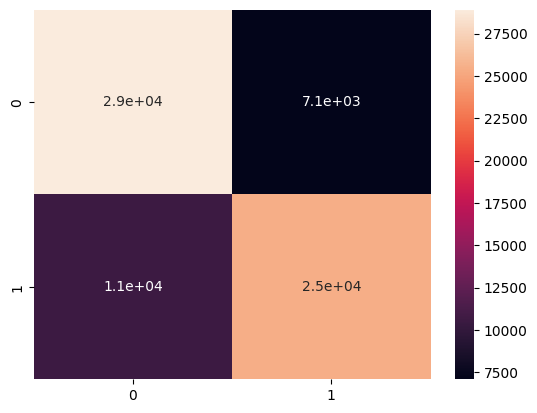

In [238]:
sns.heatmap(cm, annot=True);

In [239]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

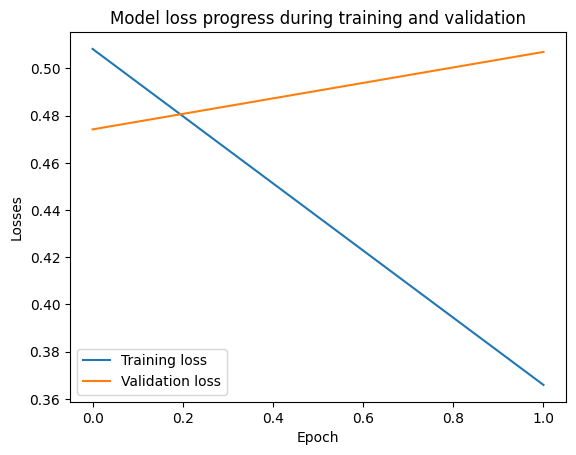

In [240]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Training loss', 'Validation loss'])

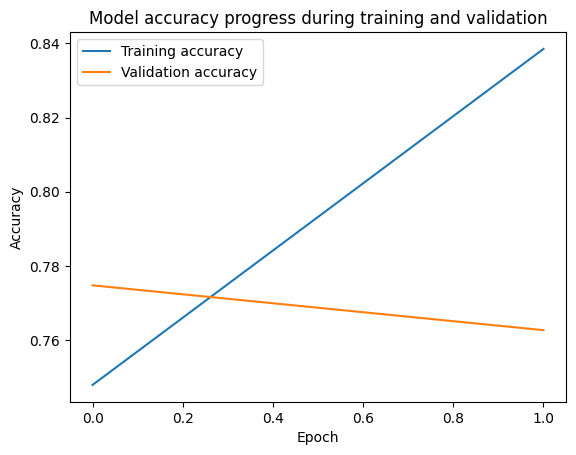

In [241]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])

In [246]:
text = 'i hate you'
text = tokenizer.encode(text)
text

[272, 65, 3160]

In [247]:
Dcnn(np.array([text]), training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.02076417]], dtype=float32)>

In [249]:
text2 = 'you look like funny'
text2 = tokenizer.encode(text2)
text2

[4121, 101, 7, 710]

In [251]:
Dcnn(np.array([text2]), training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.8709263]], dtype=float32)>